# TP: Thin Plate Spline

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

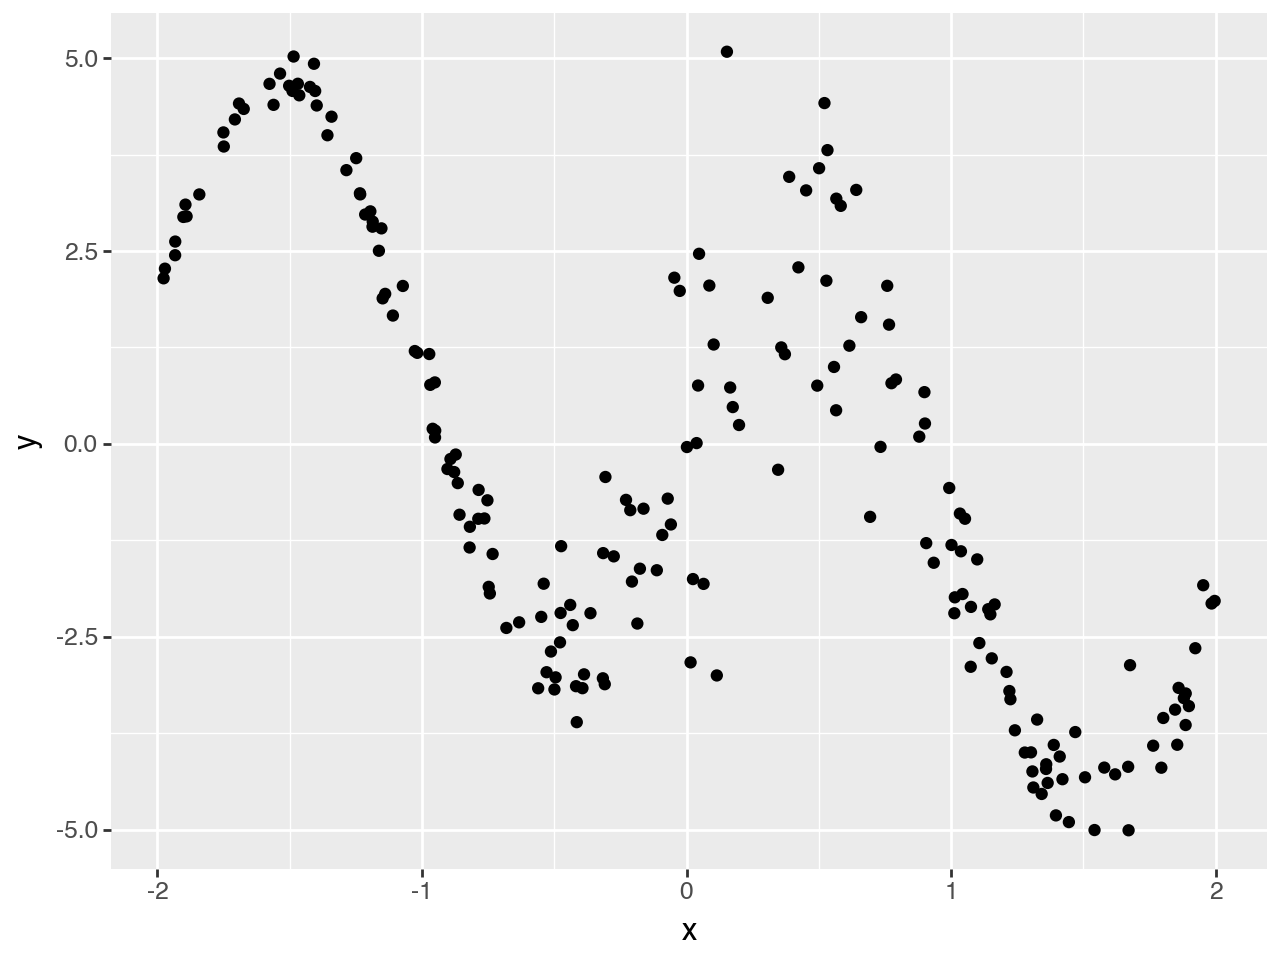

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

In [4]:
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [5]:
loc += tb.tp("x", k=20)
scale += tb.tp("x", k=20)

### Build and plot model

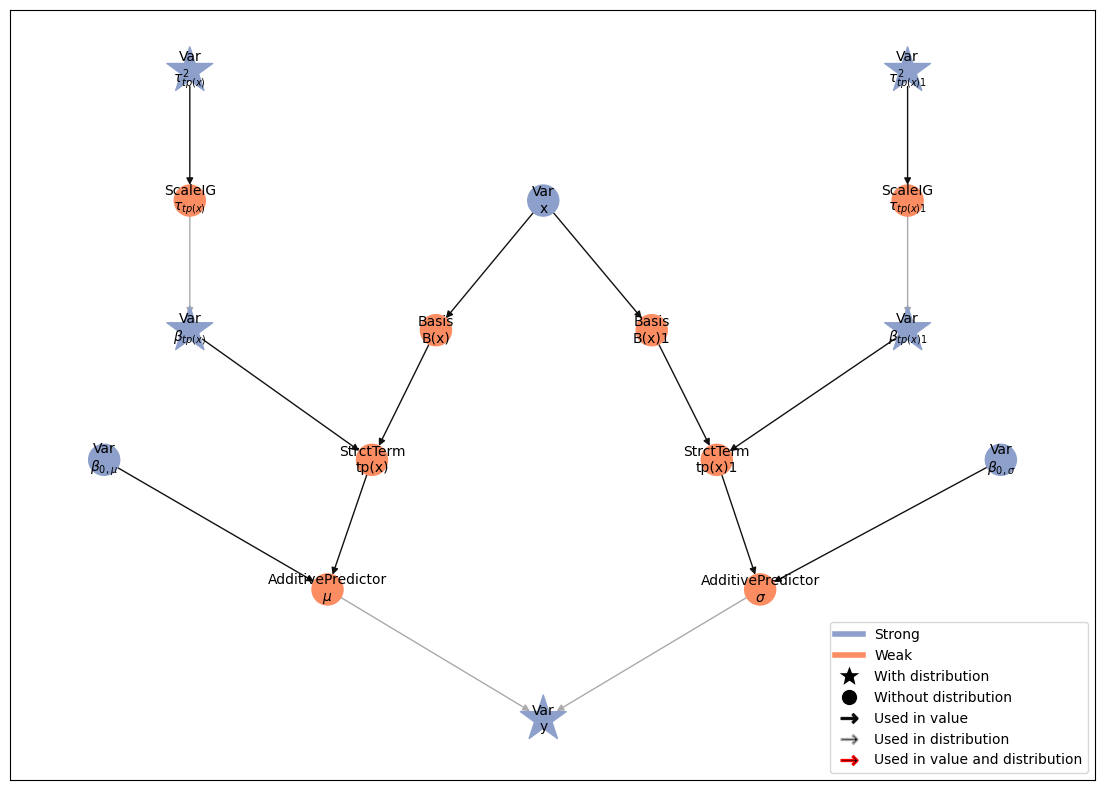

In [6]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [7]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{tp(x)1}$', '$\\tau_{tp(x)1}^2$', '$\\beta_{0,\\mu}$', '$\\beta_{tp(x)}$', '$\\tau_{tp(x)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:03<00:00,  3.27chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [8]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel        mean          sd      q_0.05  \
parameter          index                                                  
$\beta_{0,\mu}$    ()     kernel_03   -0.319492    0.058619   -0.417282   
$\beta_{0,\sigma}$ ()     kernel_00   -0.633012    0.054018   -0.720973   
$\beta_{tp(x)1}$   (0,)   kernel_01   -0.223218    3.381989   -5.825364   
                   (1,)   kernel_01   -0.651185    3.449494   -6.292287   
                   (2,)   kernel_01   -0.388206    3.363310   -5.801289   
                   (3,)   kernel_01   -0.188393    3.393148   -5.681811   
                   (4,)   kernel_01    0.161879    3.360948   -5.370816   
                   (5,)   kernel_01   -0.309639    3.443770   -5.932868   
                   (6,)   kernel_01    0.809840    3.432589   -4.439904   
                   (7,)   kernel_01    1.374591    3.457020   -3.672742   
                   (8,)   kernel_01   -0.379438    3.039759   -5.486038   
                   (9,)   kernel_01    0.636093    3.227236   -4.391140   
                   (10,)  kernel_01   -0.946280    3.241883   -6.405692   
                   (11,)  kernel_01    1.580806    2.706721   -2.671009   
                   (12,)  kernel_01    1.673710    2.902806   -2.619197   
                   (13,)  kernel_01   -4.757657    2.222360   -8.588407   
                   (14,)  kernel_01   -0.718017    2.041734   -4.166221   
                   (15,)  kernel_01    5.139132    0.955577    3.641691   
                   (16,)  kernel_01   -0.024585    1.100135   -1.825384   
                   (17,)  kernel_01   -0.066763    2.001000   -3.337880   
                   (18,)  kernel_01    3.526665    6.968064   -8.181623   
$\beta_{tp(x)}$    (0,)   kernel_04   17.374926   12.048872   -2.115159   
                   (1,)   kernel_04   -8.206913   17.057421  -36.587266   
                   (2,)   kernel_04   -6.139669   16.142166  -33.055743   
                   (3,)   kernel_04    6.755631   12.783772  -14.409870   
                   (4,)   kernel_04    4.613989   17.254919  -23.685720   
                   (5,)   kernel_04    8.255840   10.909239  -10.050988   
                   (6,)   kernel_04   16.417242   13.566302   -5.733943   
                   (7,)   kernel_04   -1.876089   10.845407  -19.825790   
                   (8,)   kernel_04    0.418349    9.047864  -14.436178   
                   (9,)   kernel_04  -11.152001    9.711149  -27.169579   
                   (10,)  kernel_04   -2.454368    9.581319  -18.239215   
                   (11,)  kernel_04  -12.750726    4.834691  -20.740265   
                   (12,)  kernel_04   -3.595982    5.778088  -12.961833   
                   (13,)  kernel_04  -58.499371    2.609229  -62.750878   
                   (14,)  kernel_04   41.967918    3.651897   35.864888   
                   (15,)  kernel_04    2.158853    1.358711   -0.054415   
                   (16,)  kernel_04    7.572556    1.456800    5.200209   
                   (17,)  kernel_04    4.224003    3.875293   -2.297158   
                   (18,)  kernel_04   95.929138   11.976497   75.981076   
$\tau_{tp(x)1}^2$  ()     kernel_02   11.939083   10.116852    2.905346   
$\tau_{tp(x)}^2$   ()     kernel_05  460.618439  186.002197  239.091196   

                               q_0.5      q_0.95  sample_size     ess_bulk  \
parameter          index                                                     
$\beta_{0,\mu}$    ()      -0.318300   -0.223115         4000   759.178939   
$\beta_{0,\sigma}$ ()      -0.633687   -0.543151         4000  3654.875916   
$\beta_{tp(x)1}$   (0,)    -0.159784    5.198373         4000  3923.407807   
                   (1,)    -0.535440    4.735307         4000  3724.497219   
                   (2,)    -0.358361    5.081929         4000  3755.369546   
                   (3,)    -0.162407    5.377168         4000  3724.284559   
                   (4,)     0.231757    5.434961       

## Predictions

In [9]:
samples = results.get_posterior_samples()

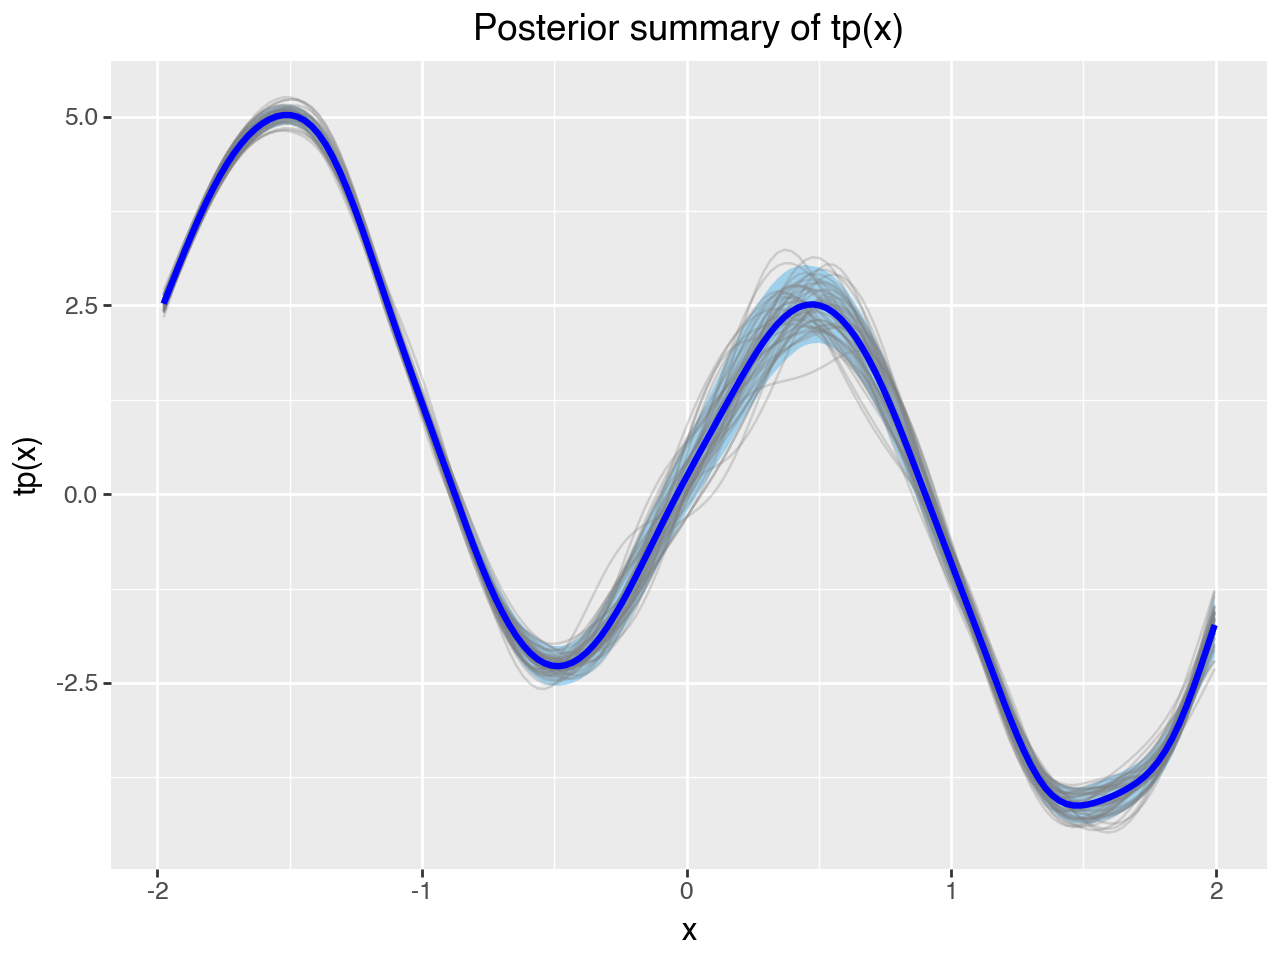

In [10]:
gam.plot_1d_smooth(term=model.vars["tp(x)"], samples=samples)

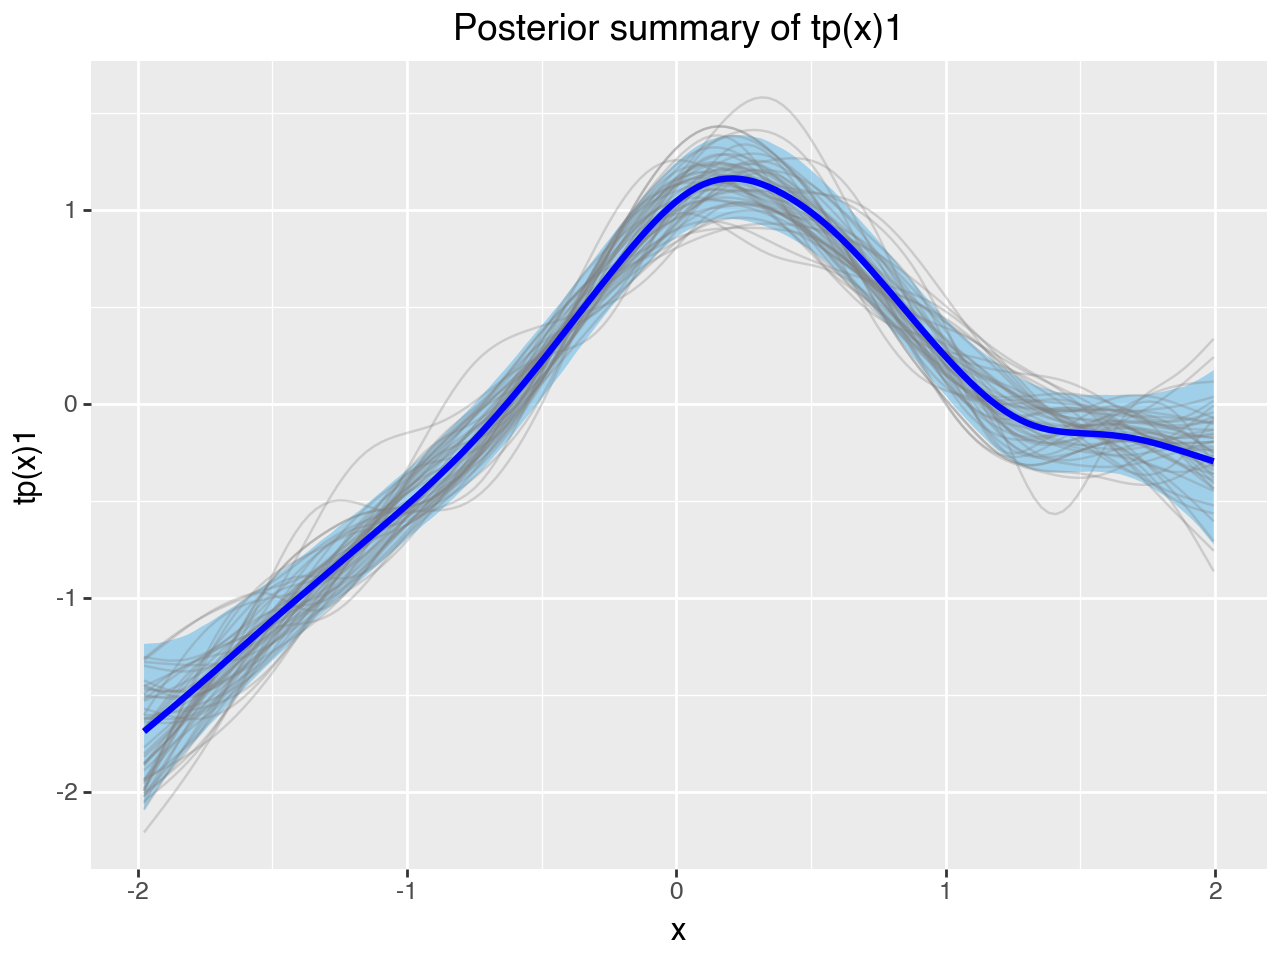

In [11]:
gam.plot_1d_smooth(term=model.vars["tp(x)1"], samples=samples)